# instalar librerias

In [41]:
!pip install pandas geopandas networkx matplotlib scikit-learn torch torch-geometric osmnx


# zona de import y dataset

In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

plt.rcParams["figure.figsize"] = (8, 8)
ruta_csv = "/content/Siniestros_urbanos_Metropolitana_2024.csv"
df = pd.read_csv(ruta_csv)
df.head()


X             Y  FID   Año  IdAccident    Latitud   longitud  \
0 -7.862396e+06 -3.955511e+06    1  2024     1587058 -33.452426 -70.629108   
1 -7.859285e+06 -3.955788e+06    2  2024     1587059 -33.454502 -70.601157   
2 -7.927226e+06 -3.987380e+06    3  2024     1587079 -33.690955 -71.211487   
3 -7.929043e+06 -3.987076e+06    4  2024     1587081 -33.688686 -71.227804   
4 -7.872821e+06 -3.960612e+06    5  2024     1587085 -33.490650 -70.722755   

   ClaseAccid                   Fecha                    Hora  ... Ubicaci_1  \
0           1  2024/01/26 00:00:00+00  1899/12/30 00:00:00+00  ...             
1           1  2024/01/23 00:00:00+00  1899/12/30 00:00:00+00  ...             
2           1  2024/01/16 00:00:00+00  1899/12/30 00:00:00+00  ...             
3           1  2024/01/16 00:00:00+00  1899/12/30 00:00:00+00  ...             
4           1  2024/01/27 00:00:00+00  1899/12/30 00:00:00+00  ...             

                      Calzada Tipo_Calza Estado_Cal Condición Estado_Atm  \
0  BIDIRECCIONAL CON BANDEJON   CONCRETO      BUENO      SECO  DESPEJADO   
1  BIDIRECCIONAL CON BANDEJON   CONCRETO      BUENO      SECO  DESPEJADO   
2              UNIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   
3              UNIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   
4               BIDIRECCIONAL    ASFALTO      BUENO      SECO  DESPEJADO   

  Fallecidos Graves Menos_Grav Leves  
0          0      0          0     0  
1          0      0          0     1  
2          0      0          0     0  
3          0      0          0     3  
4          0      0          0     0  

[5 rows x 33 columns]

#limpiar datos (cada nodo será una intersección)

In [43]:
df = df.dropna(subset=["Latitud", "longitud"])
for col in ["Intersecci", "Calle_Uno", "Calle_Dos", "Comuna"]:
    if col in df.columns:
        df[col] = df[col].fillna("")
    else:
        raise ValueError(f"Falta la columna '{col}' en el CSV, ajústala en el código.")

# node_id: primero intersección
# si esta vacio, Calle_Uno - Calle_Dos
df["node_id"] = df["Intersecci"].str.strip()

mask_empty = df["node_id"] == ""
df.loc[mask_empty, "node_id"] = (
    df.loc[mask_empty, "Calle_Uno"].str.strip()
    + " - "
    + df.loc[mask_empty, "Calle_Dos"].str.strip()
)

mask_still_empty = df["node_id"].str.strip().isin(["", "-", " - "])
df.loc[mask_still_empty, "node_id"] = (
    df.loc[mask_still_empty, "Latitud"].round(5).astype(str)
    + ","
    + df.loc[mask_still_empty, "longitud"].round(5).astype(str)
)

df[["Latitud", "longitud", "Comuna", "node_id"]].head()


Latitud   longitud     Comuna                               node_id
0 -33.452426 -70.629108      NUNOA         GRAL BUSTAMANTE - IRARRAZAVAL
1 -33.454502 -70.601157      NUNOA       IRARRAZAVAL - JOSE LUIS ARANEDA
2 -33.690955 -71.211487  MELIPILLA                 BARRALES - FUENZALIDA
3 -33.688686 -71.227804  MELIPILLA           AURORA URRUTIA - EL MIRADOR
4 -33.490650 -70.722755  CERRILLOS  LO ERRAZURIZ - PDTE SALVADOR ALLENDE

# features y etiquetas por nodo

In [44]:
agg = (
    df.groupby("node_id")
      .agg(
          lat=("Latitud", "mean"),
          lon=("longitud", "mean"),
          comuna=("Comuna", lambda x: x.mode().iat[0] if len(x.mode()) > 0 else ""),
          accidentes_totales=("FID", "count"),
          fallecidos=("Fallecidos", "sum"),
          graves=("Graves", "sum"),
          menos_grav=("Menos_Grav", "sum"),
          leves=("Leves", "sum"),
      )
      .reset_index()
)
# defino un ponderador de severidad
agg["severidad"] = (
    3 * agg["fallecidos"]
    + 2 * agg["graves"]
    + 1 * agg["menos_grav"]
)

agg[["node_id", "lat", "lon", "accidentes_totales", "severidad"]].head()


node_id        lat        lon  accidentes_totales  \
0               - 1 DE MAYO -33.494017 -70.686489                   2   
1                 - 1 NORTE -33.812251 -70.741218                   1   
2               - 1 ORIENTE -33.142724 -70.800834                   1   
3                   - 1 SUR -33.264233 -70.802766                   3   
4  - 10 DE JULIO HUAMACHUCO -33.454147 -70.657462                   1   

   severidad  
0          0  
1          0  
2          0  
3          0  
4          0

# etiquetar por clases

In [45]:
def clasificar_severidad(s):
    if s == 0:
        return 0  # sin lesiones
    elif s <= 2:
        return 1  # baja
    elif s <= 4:
        return 2  # media
    else:
        return 3  # alta

agg["label"] = agg["severidad"].apply(clasificar_severidad)
print("Distribución de clases (recuento):")
print(agg["label"].value_counts().sort_index())
print("\nDistribución de clases (proporción):")
print(agg["label"].value_counts(normalize=True).sort_index())


Distribución de clases (recuento):
label
0    7760
1    1203
2     271
3     131
Name: count, dtype: int64

Distribución de clases (proporción):
label
0    0.828617
1    0.128457
2    0.028938
3    0.013988
Name: proportion, dtype: float64


# gafo donde los nodos son intersecciones y las aristas es la cercania de los nodos

In [46]:
coords = agg[["lat", "lon"]].values
k_vecinos = 6
knn = NearestNeighbors(n_neighbors=k_vecinos, metric="euclidean")
knn.fit(coords)
distancias, indices = knn.kneighbors(coords)

G = nx.Graph()

# agregamos nodos con atributos
for idx, fila in agg.iterrows():
    G.add_node(
        idx,
        node_id=fila["node_id"],
        lat=float(fila["lat"]),
        lon=float(fila["lon"]),
        comuna=str(fila["comuna"]),
        accidentes_totales=int(fila["accidentes_totales"]),
        fallecidos=int(fila["fallecidos"]),
        graves=int(fila["graves"]),
        menos_grav=int(fila["menos_grav"]),
        leves=int(fila["leves"]),
        severidad=float(fila["severidad"]),
        label=int(fila["label"])
    )

#Agregamos aristas segun vecinos más cercanoss
for i, (neighbors, dists) in enumerate(zip(indices, distancias)):
    for j, dist in zip(neighbors[1:], dists[1:]):
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight=float(dist))

print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")


Número de nodos: 9365
Número de aristas: 30387


# plot grafo

In [47]:
pos = {n: (G.nodes[n]["lon"], G.nodes[n]["lat"]) for n in G.nodes}
colors = {0: "blue", 1: "green", 2: "orange", 3: "red"}
plt.figure(figsize=(8, 8))
for u, v in G.edges(): # aristas
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    plt.plot([x0, x1], [y0, y1], linewidth=0.2, alpha=0.1, color="gray")

for c, color in colors.items():
    nodes_c = [n for n in G.nodes if G.nodes[n]["label"] == c]
    if not nodes_c:
        continue
    plt.scatter(
        [pos[n][0] for n in nodes_c],
        [pos[n][1] for n in nodes_c],
        s=6,
        color=color,
        alpha=0.8,
        label=f"Clase {c}"
    )

plt.xlabel("longitud")
plt.ylabel("latitud")
plt.title("Grafo de intersecciones de siniestros por nivel de severidad")
plt.legend()
plt.axis("equal")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


# hacemos las features

In [48]:
data = from_networkx(G)
features = np.vstack([
    agg["accidentes_totales"].values,
    agg["fallecidos"].values,
    agg["graves"].values,
    agg["menos_grav"].values,
    agg["leves"].values,
]).T

data.x = torch.tensor(features, dtype=torch.float32)
data.y = torch.tensor(agg["label"].values, dtype=torch.long)

print(data)


Data(edge_index=[2, 60057], node_id=[9365], lat=[9365], lon=[9365], comuna=[9365], accidentes_totales=[9365], fallecidos=[9365], graves=[9365], menos_grav=[9365], leves=[9365], severidad=[9365], label=[9365], weight=[60057], num_nodes=9365, x=[9365, 5], y=[9365])


# split de datos

In [49]:
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.shuffle(indices)

train_size = int(0.8 * num_nodes)
train_idx = torch.tensor(indices[:train_size], dtype=torch.long)
test_idx  = torch.tensor(indices[train_size:], dtype=torch.long)

len(train_idx), len(test_idx)


(7492, 1873)

# modelo simple por ahora xd

In [50]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(
    in_channels=data.x.shape[1],
    hidden_channels=32,
    out_channels=4  # clases 0,1,2,3
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


In [56]:
def evaluar(model, data, idx):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        acc = (pred[idx] == data.y[idx]).float().mean().item()
    return acc

for epoch in range(1, 501):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = evaluar(model, data, train_idx)
        test_acc = evaluar(model, data, test_idx)
        print(f"Epoch {epoch:3d} | Loss {loss.item():.4f} | "
              f"Train acc {train_acc:.3f} | Test acc {test_acc:.3f}")


Epoch  20 | Loss 0.4208 | Train acc 0.832 | Test acc 0.826
Epoch  40 | Loss 0.4165 | Train acc 0.832 | Test acc 0.825
Epoch  60 | Loss 0.4129 | Train acc 0.832 | Test acc 0.824
Epoch  80 | Loss 0.4099 | Train acc 0.832 | Test acc 0.825
Epoch 100 | Loss 0.4073 | Train acc 0.832 | Test acc 0.825
Epoch 120 | Loss 0.4051 | Train acc 0.832 | Test acc 0.825
Epoch 140 | Loss 0.4033 | Train acc 0.832 | Test acc 0.826
Epoch 160 | Loss 0.4017 | Train acc 0.832 | Test acc 0.826
Epoch 180 | Loss 0.4005 | Train acc 0.833 | Test acc 0.826
Epoch 200 | Loss 0.3995 | Train acc 0.832 | Test acc 0.825
Epoch 220 | Loss 0.3986 | Train acc 0.832 | Test acc 0.825
Epoch 240 | Loss 0.3980 | Train acc 0.832 | Test acc 0.825
Epoch 260 | Loss 0.3974 | Train acc 0.832 | Test acc 0.825
Epoch 280 | Loss 0.3969 | Train acc 0.832 | Test acc 0.825
Epoch 300 | Loss 0.3965 | Train acc 0.832 | Test acc 0.825
Epoch 320 | Loss 0.3962 | Train acc 0.831 | Test acc 0.825
Epoch 340 | Loss 0.3959 | Train acc 0.832 | Test acc 0.8

In [57]:
model.eval()
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1).cpu().numpy()
    true  = data.y.cpu().numpy()

print("Classification report (solo test):")
print(classification_report(true[test_idx], preds[test_idx], digits=3))
print("Matriz de confusión (test):")
print(confusion_matrix(true[test_idx], preds[test_idx]))


Classification report (solo test):
              precision    recall  f1-score   support

           0      0.833     0.994     0.906      1550
           1      0.227     0.021     0.038       242
           2      1.000     0.019     0.036        54
           3      0.000     0.000     0.000        27

    accuracy                          0.825      1873
   macro avg      0.515     0.258     0.245      1873
weighted avg      0.747     0.825     0.756      1873

Matriz de confusión (test):
[[1540    9    0    1]
 [ 237    5    0    0]
 [  47    6    1    0]
 [  25    2    0    0]]


In [58]:
import geopandas as gpd
from shapely.geometry import Point, LineString

nodes_list = []
for n, data_n in G.nodes(data=True):
    nodes_list.append({
        "node": n,
        "label": data_n["label"],
        "accidentes_totales": data_n["accidentes_totales"],
        "geometry": Point(data_n["lon"], data_n["lat"])
    })

gdf_nodes = gpd.GeoDataFrame(nodes_list, crs="EPSG:4326")
edges_list = []
for u, v, data_e in G.edges(data=True):
    p1 = Point(G.nodes[u]["lon"], G.nodes[u]["lat"])
    p2 = Point(G.nodes[v]["lon"], G.nodes[v]["lat"])
    edges_list.append({
        "u": u,
        "v": v,
        "geometry": LineString([p1, p2])
    })

gdf_edges = gpd.GeoDataFrame(edges_list, crs="EPSG:4326")


In [59]:
!pip install contextily

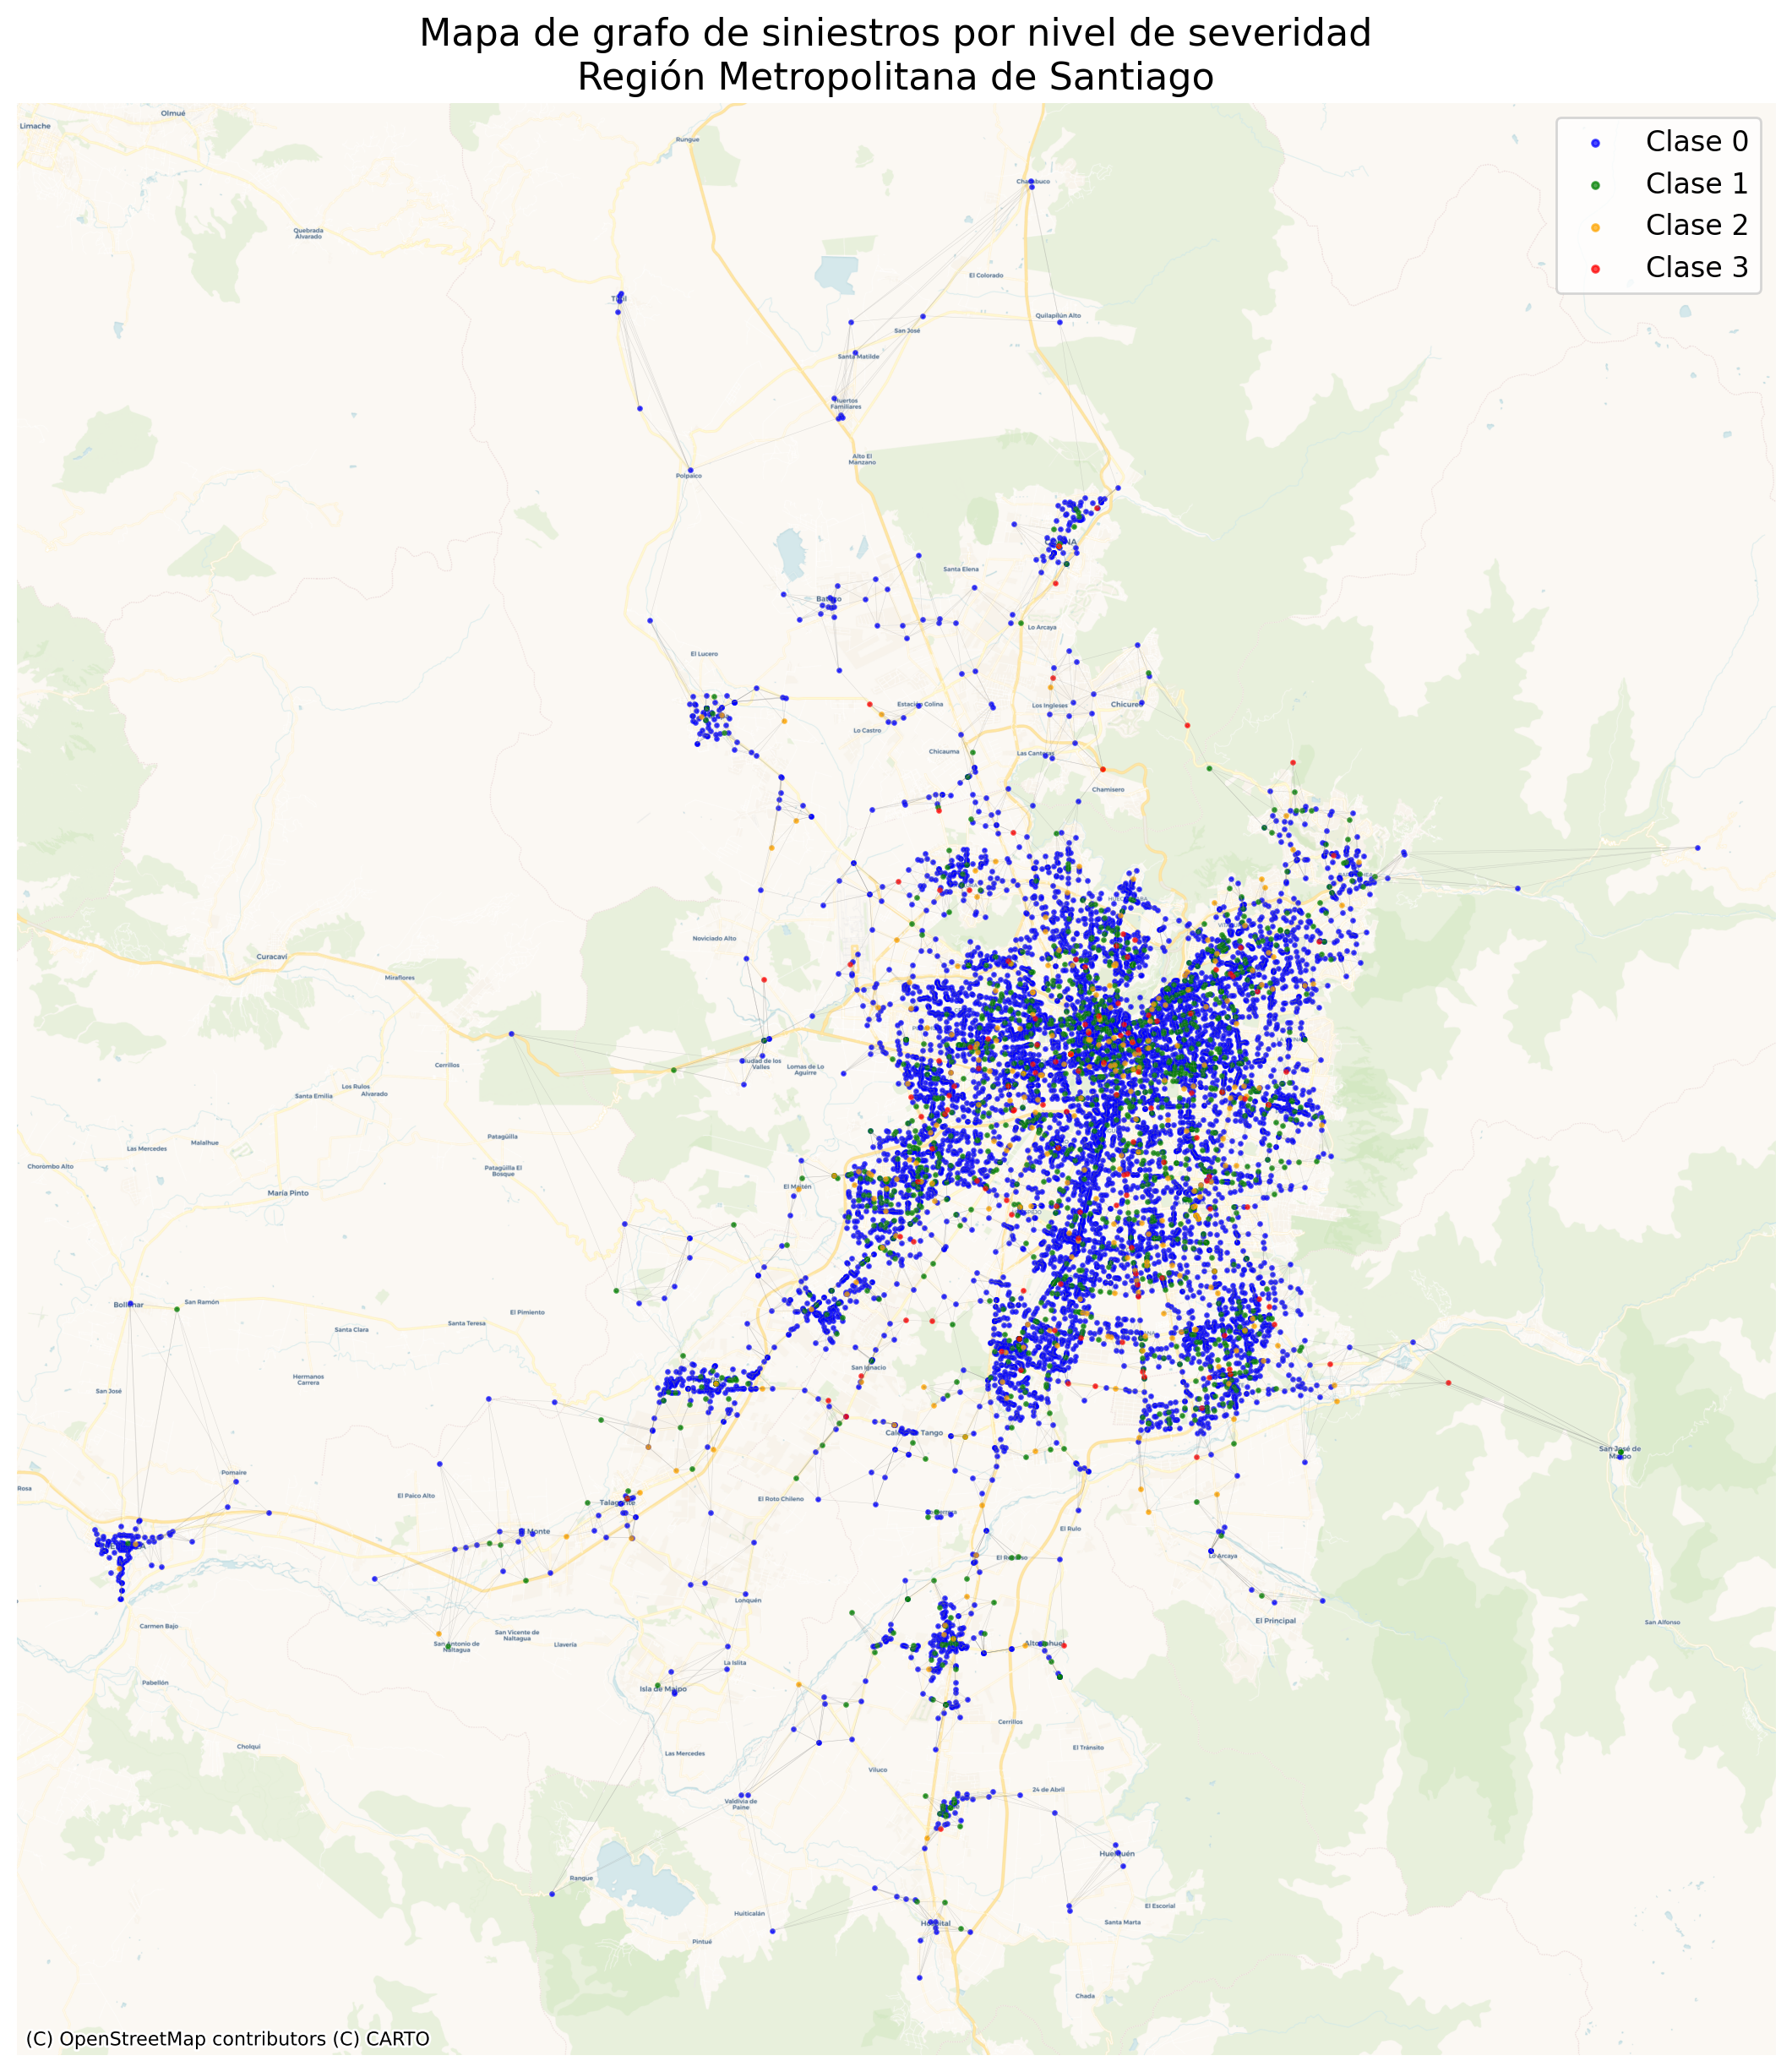

In [61]:
import contextily as cx
import matplotlib.pyplot as plt

gdf_nodes_3857 = gdf_nodes.to_crs(epsg=3857)
gdf_edges_3857 = gdf_edges.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15), dpi=200)

gdf_edges_3857.plot(ax=ax, linewidth=0.2, alpha=0.25, color="gray")

colors = {0: "blue", 1: "green", 2: "orange", 3: "red"}

for c, color in colors.items():
    gdf_c = gdf_nodes_3857[gdf_nodes_3857["label"] == c]
    if len(gdf_c) == 0:
        continue
    gdf_c.plot(
        ax=ax,
        markersize=2,
        color=color,
        alpha=0.7,
        label=f"Clase {c}"
    )

ax.set_xlim(gdf_nodes_3857.total_bounds[0] - 5000,
            gdf_nodes_3857.total_bounds[2] + 5000)
ax.set_ylim(gdf_nodes_3857.total_bounds[1] - 5000,
            gdf_nodes_3857.total_bounds[3] + 5000)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Voyager,
    zoom=12
)

ax.set_axis_off()
ax.set_title(
    "Mapa de grafo de siniestros por nivel de severidad\nRegión Metropolitana de Santiago",
    fontsize=16
)
ax.legend(markerscale=2, fontsize=12)
plt.show()
